<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Functions" data-toc-modified-id="Functions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Functions</a></span></li><li><span><a href="#M31" data-toc-modified-id="M31-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>M31</a></span></li><li><span><a href="#NGC-628" data-toc-modified-id="NGC-628-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>NGC 628</a></span></li><li><span><a href="#NGC-1530" data-toc-modified-id="NGC-1530-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>NGC 1530</a></span></li><li><span><a href="#NGC-4565" data-toc-modified-id="NGC-4565-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>NGC 4565</a></span></li><li><span><a href="#NGC-3976" data-toc-modified-id="NGC-3976-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>NGC 3976</a></span></li><li><span><a href="#NGC-4559" data-toc-modified-id="NGC-4559-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>NGC 4559</a></span></li></ul></div>

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import time
import seaborn as sns

import astropy
import astropy.units as u
import astropy.constants as const
from astropy.table import Table as t
from astropy.table import vstack, join
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

In [3]:
fOH = 1667.35903 * u.MHz    # OH rest frequency
fHI = 1420.40575 * u.MHz    # HI rest frequency

In [106]:
#plotting styles
clean_plots = lambda: sns.set(context='paper', font_scale=1.2, style='ticks', palette = 'flare_r', 
                         rc={'figure.figsize':(4,3), 'xtick.bottom': True, 'ytick.left':True, 
                              'figure.dpi':200, 'figure.facecolor':'w', 'errorbar.capsize': 2, 
                              'xtick.direction': 'in', 'ytick.direction': 'in', 'font.family':'monospace'})

clean_plots()

## Functions

In [109]:
c_kms = const.c.to(u.km/u.s).value

def f2v_HI(x):
    # frequency to velocity HI
    return c_kms * (fHI.value-x)/fHI.value

def v2f_HI(x):
    # velocity to frequency HI
    return fHI.value*(1-x/c_kms)

def f2v_OH(x):
    # frequency to velocity OH
    return c_kms * (fOH.value-x)/fOH.value

def v2f_OH(x):
    # velocity to frequency OH
    return fOH.value*(1-x/c_kms)

In [17]:
def rescale(data):
    # rescales data from 0 to 1
    dmin = np.min(data)
    dmax = np.max(data)
    return (data-dmin)/(dmax-dmin)

In [299]:
def baseline(xdata, ydata, z, deg=4):
    # mask out lines
    mask_galactic_HI = ((xdata<=fHI.value-0.5) | (xdata>=fHI.value+0.5))
    mask_HI_line = ((xdata<=(fHI.value/(1+z))-0.75) | (xdata>=(fHI.value/(1+z))+0.75)) 
    mask_OH_line = ((xdata<=(fOH.value/(1+z))-0.75) | (xdata>=(fOH.value/(1+z))+0.75)) 
    mask = mask_galactic_HI & mask_HI_line & mask_OH_line
    
    # fit to non-line area
    fit = np.polyfit(xdata[mask], ydata[mask], deg)
    
    # construct baselined polynomial
    new_vals = np.zeros(len(ydata))
    for i in range(deg+1):
        new_vals = new_vals + (fit[i]*(xdata**(deg-i)))
    return new_vals

In [1]:
from astropy.convolution import convolve, Box1DKernel, Gaussian1DKernel

def smooth_spectra(xdata, ydata, num=10, kernel='boxcar'):
    # smooth spectra including boxcar and gaussian options
    # also decimates
    if kernel == 'boxcar':
        flux_bin = convolve(np.array(ydata), Box1DKernel(num))
        
    elif kernel == 'gaussian':
        flux_bin = convolve(np.array(ydata), Gaussian1DKernel(num))
        
    else:
        raise ValueError("Kernel options are 'boxcar' or 'gaussian'")
    
    return xdata[int(num/2)::num], flux_bin[int(num/2)::num]

In [244]:
from scipy.optimize import curve_fit

def gauss(x,a,x0,sigma):
    # gaussian function
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

def gauss_fit(xdata, ydata, z):
    # fit a gaussian
    n = len(xdata)                         
    mean = fHI.value/(1+z)
    sigma = sum(ydata*(xdata-mean)**2)/n

    popt,pcov = curve_fit(gauss,xdata,ydata,p0=[1,mean,sigma])
    
    return popt

In [488]:
def reduce_data(file, z, plot_steps=False, deg=4, num=3, smooth=False):
    # loads data
    data = t.read(file, format='ascii')
    
    # create cols for both high res and low res data
    low_res_cols = ['Freq2', 'YY2', 'XX2']
    hi_res_cols  = ['Freq1', 'XX1', 'YY1','Freq2','XX2','YY2']
    
    # checks if it's the hi res spectra 
    hi_res = len(data.colnames)==len(hi_res_cols)
    
    # rename accordingly
    if hi_res:
        for i in range(6):
            data['col'+str(int(i+1))].name = hi_res_cols[i]
    else:
        for i in range(3):
            data['col'+str(int(i+1))].name = low_res_cols[i]
    
    # calculate velocities
    if hi_res:
        data['Velo1'] = const.c.to(u.km/u.s).value * (fOH.value-data['Freq1'])/fOH.value
    data['Velo2'] = const.c.to(u.km/u.s).value * (fHI.value-data['Freq2'])/fHI.value
    
    # determine how many spectra to process
    if hi_res:
        nums = ['1','2']
    else:
        nums = ['2']
    
    # iterate through spectra
    for i in nums:
        # fit baseline to each polarization
        temp_baseline_XX = baseline(data['Freq'+i], data['XX'+i], z, deg=deg)
        temp_baseline_YY = baseline(data['Freq'+i], data['YY'+i], z, deg=deg)
        
        # baseline each
        data['XX'+i+'_baselined'] = data['XX'+i]-temp_baseline_XX
        data['YY'+i+'_baselined'] = data['YY'+i]-temp_baseline_YY
        
        # average polarizations
        data['Spec'+i] = (data['XX'+i+'_baselined'] + data['YY'+i+'_baselined'])/2
        
        # plots all steps
        if plot_steps:
            plt.figure(figsize=(7,2))
            plt.plot(data['Freq'+i], data['XX'+i], color='b', label='XX')
            plt.plot(data['Freq'+i], data['YY'+i], color='r', label='YY')
            plt.ylabel('Uncalibrated\nAmplitude', fontsize='small')
            plt.xlabel('Frequency (MHz)')
            plt.legend(loc='upper left')
            plt.title('Original')
            plt.yticks([])
            plt.show()

            plt.figure(figsize=(7,2))
            plt.plot(data['Freq'+i], data['XX'+i+'_baselined'], color='b', label='XX')
            plt.plot(data['Freq'+i], data['YY'+i+'_baselined'], color='r', label='YY')
            plt.ylabel('Uncalibrated\nAmplitude', fontsize='small')
            plt.xlabel('Frequency (MHz)')
            plt.legend(loc='upper left')
            plt.title('Baselined')
            plt.yticks([])
            plt.show()
        
    # Plot reduced spectra
    plt.figure(figsize=(7,2))
    plt.step(data['Freq2'], data['Spec2'], color='purple', label='Averaged')
    plt.ylabel('Uncalibrated\nAmplitude', fontsize='small')
    plt.xlabel('Frequency (MHz)')
    ax = plt.gca()
    secax = ax.secondary_xaxis('top', functions=(f2v_HI, v2f_HI))
    secax.set_xlabel('Velocity (km s$^{-1}$)')
    plt.yticks([])
    plt.show()
    
    # if we're smoothing, smooth, plot, and return data
    if smooth:
        freq_smooth, spec_smooth = smooth_spectra(data['Freq2'], data['Spec2'], num=num, kernel='boxcar')
        
        plt.figure(figsize=(7,2))
        plt.step(freq_smooth, spec_smooth, color='purple', label='Averaged')
        plt.ylabel('Uncalibrated\nAmplitude', fontsize='small')
        plt.xlabel('Frequency (MHz)')
        ax = plt.gca()
        secax = ax.secondary_xaxis('top', functions=(f2v_HI, v2f_HI))
        secax.set_xlabel('Velocity (km s$^{-1}$)')
        plt.yticks([])
        plt.show()
        
        new_data=t()
        new_data['Freq2']=freq_smooth
        new_data['Spec2']=spec_smooth
        return new_data
        
    return data

## M31

/Users/hayley/opt/anaconda3/envs/research/lib/python3.7/site-packages/ipykernel_launcher.py:25: RankWarning: Polyfit may be poorly conditioned
/Users/hayley/opt/anaconda3/envs/research/lib/python3.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned


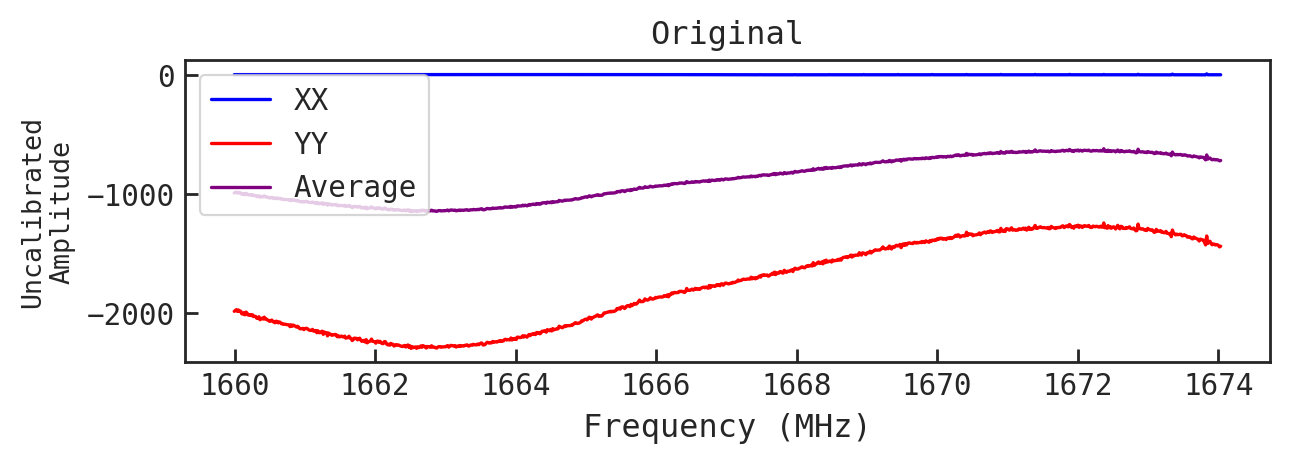

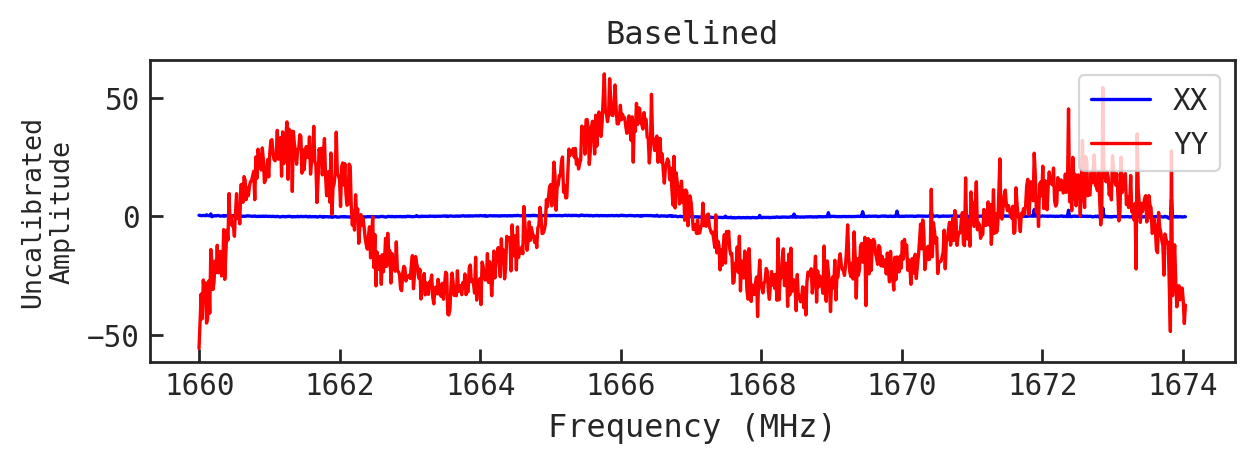

/Users/hayley/opt/anaconda3/envs/research/lib/python3.7/site-packages/ipykernel_launcher.py:25: RankWarning: Polyfit may be poorly conditioned
/Users/hayley/opt/anaconda3/envs/research/lib/python3.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned


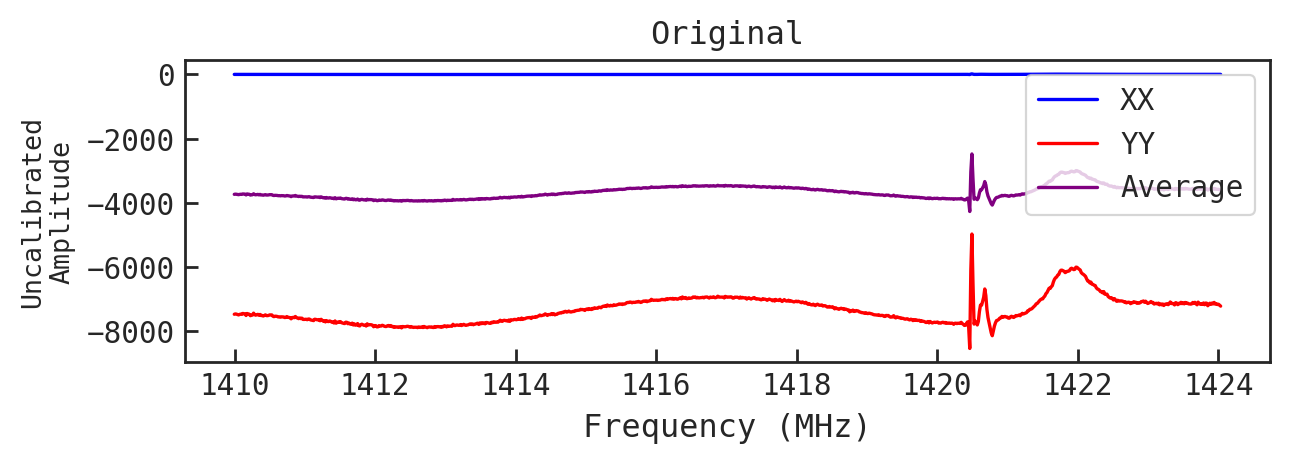

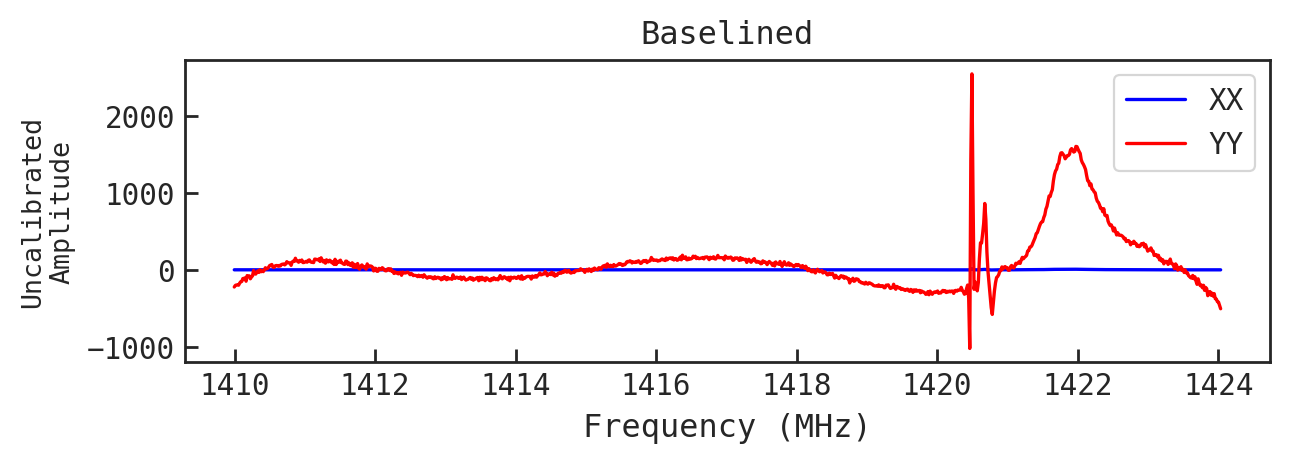

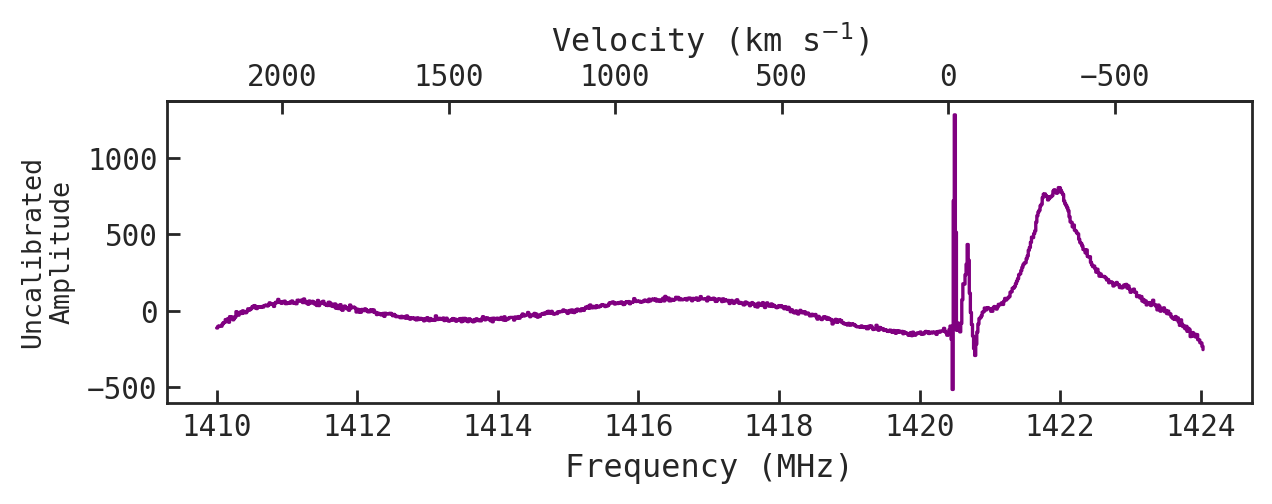

In [479]:
z_M31 = -0.001

data_M31 = reduce_data('Data/M31_data.txt', z_M31, plot_steps=True, deg=5)

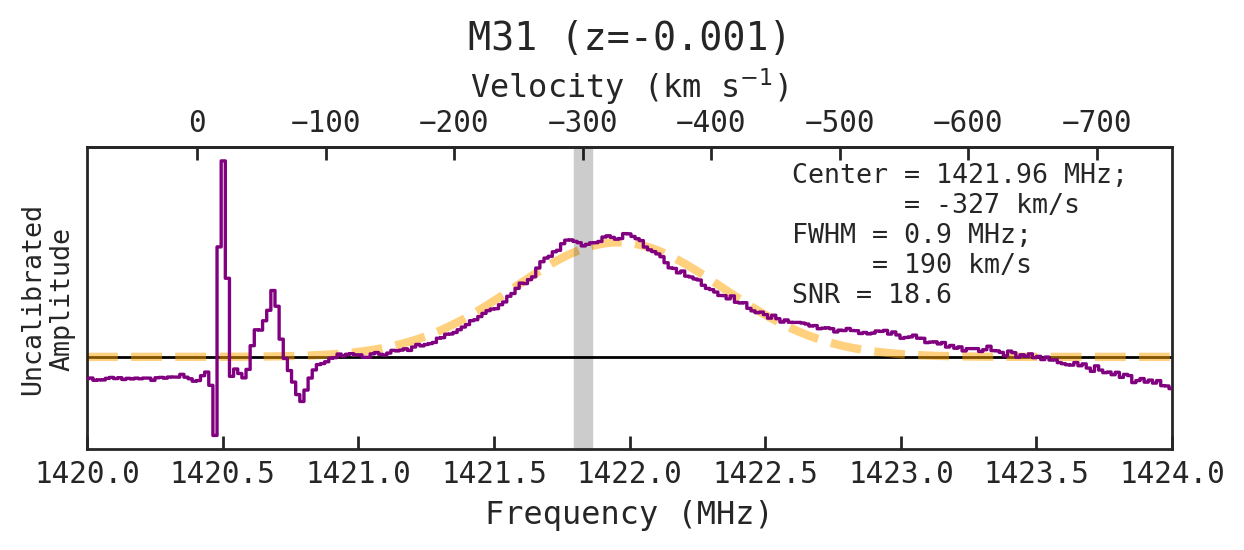

Fit Values (Assuming Gaussian)
------------------------------
Center: 1421.96 MHz; -327.57 km/s
Redshift: -0.0011
Sigma: 0.38 MHz; 80.83 km/s
FWHM: 0.9 MHz; 190.35 km/s


In [514]:
HI_mask_M31 = (data_M31['Freq2']>=1421) & (data_M31['Freq2']<=1424)
HI_fit_M31 = gauss_fit(data_M31['Freq2'][HI_mask_M31], data_M31['Spec2'][HI_mask_M31], z_M31)

amp, mu, sigma = HI_fit_M31
fwhm = sigma*2.355
sigma_kms = f2v_HI(mu-sigma/2)-f2v_HI(mu+sigma/2) 
fwhm_kms = f2v_HI(mu-fwhm/2)-f2v_HI(mu+fwhm/2) 

rms = np.std(data_M31['Spec2'][:20])
peak = np.sort(data_M31['Spec2'])[-2]
snr = peak/rms

plot_text = 'Center = '+str(np.round(mu,2))+' MHz;\n       = '+str(int(f2v_HI(mu)))+' km/s'
plot_text = plot_text + '\n' + 'FWHM = '+str(np.round(fwhm,2))+' MHz;\n     = '+str(int(fwhm_kms))+' km/s'
plot_text = plot_text + '\n' + 'SNR = '+str(np.round(snr,2))
new_xs = np.linspace(np.min(data_M31['Freq2']), np.max(data_M31['Freq2']), 10000)

plt.figure(figsize=(7,2))
plt.step(data_M31['Freq2'], data_M31['Spec2'], color='purple', label='Averaged Spectrum', zorder=3)
plt.plot(new_xs, gauss(new_xs,*HI_fit_M31), color='orange', linewidth=3, zorder=1, alpha=0.5, label='Fit Line', linestyle='dashed')
plt.axhline(0, color='k', linewidth=1.0, zorder=0)
plt.axvline(fHI.value/(z_M31+1), linewidth=7, zorder=1, alpha=0.2, color='k')
plt.ylabel('Uncalibrated\nAmplitude', fontsize='small')
plt.xlabel('Frequency (MHz)')
ax = plt.gca()
secax = ax.secondary_xaxis('top', functions=(f2v_HI, v2f_HI))
secax.set_xlabel('Velocity (km s$^{-1}$)')
ax.set_xlim([1420,1424])
ax.set_yticks([])
plt.text(0.65,0.95,plot_text,transform=ax.transAxes, va='top', fontsize='small')
# plt.legend(fontsize='small')
plt.title('M31 (z='+str(z_M31)+')', fontsize='large')
plt.show()


print('Fit Values (Assuming Gaussian)')
print('------------------------------')
print('Center:', round(mu,2), 'MHz;', round(f2v_HI(mu),2), 'km/s')
print('Redshift:', round((fHI.value/mu)-1,4))
print('Sigma:', round(sigma,2), 'MHz;', round(sigma_kms,2), 'km/s')
print('FWHM:', round(fwhm,2), 'MHz;', round(fwhm_kms,2), 'km/s')

## NGC 628

/Users/hayley/opt/anaconda3/envs/research/lib/python3.7/site-packages/ipykernel_launcher.py:25: RankWarning: Polyfit may be poorly conditioned
/Users/hayley/opt/anaconda3/envs/research/lib/python3.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned


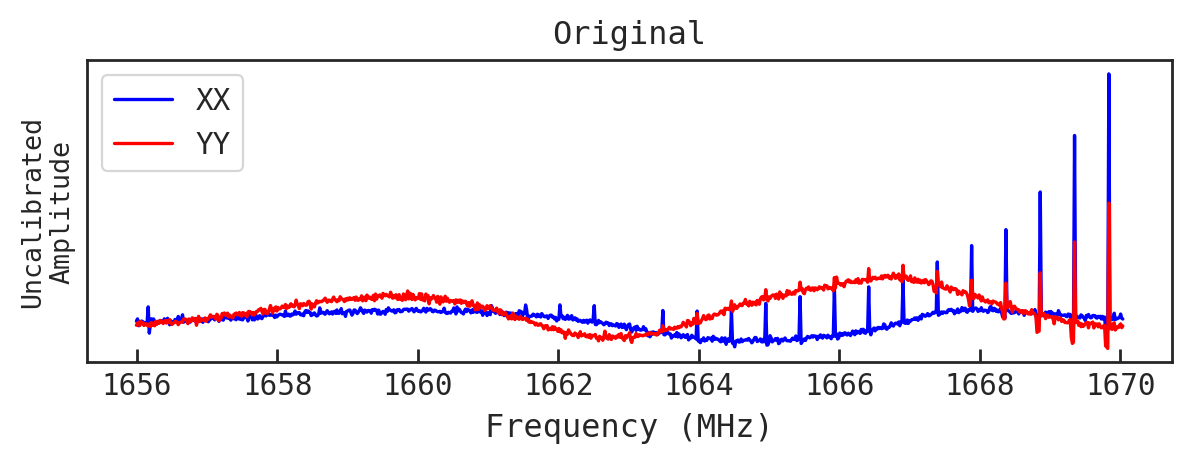

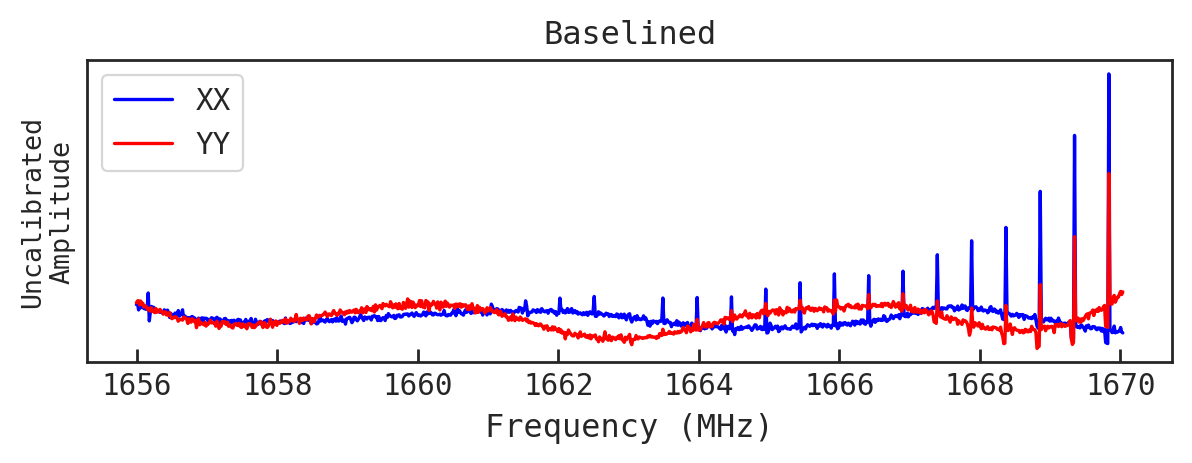

/Users/hayley/opt/anaconda3/envs/research/lib/python3.7/site-packages/ipykernel_launcher.py:25: RankWarning: Polyfit may be poorly conditioned
/Users/hayley/opt/anaconda3/envs/research/lib/python3.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned


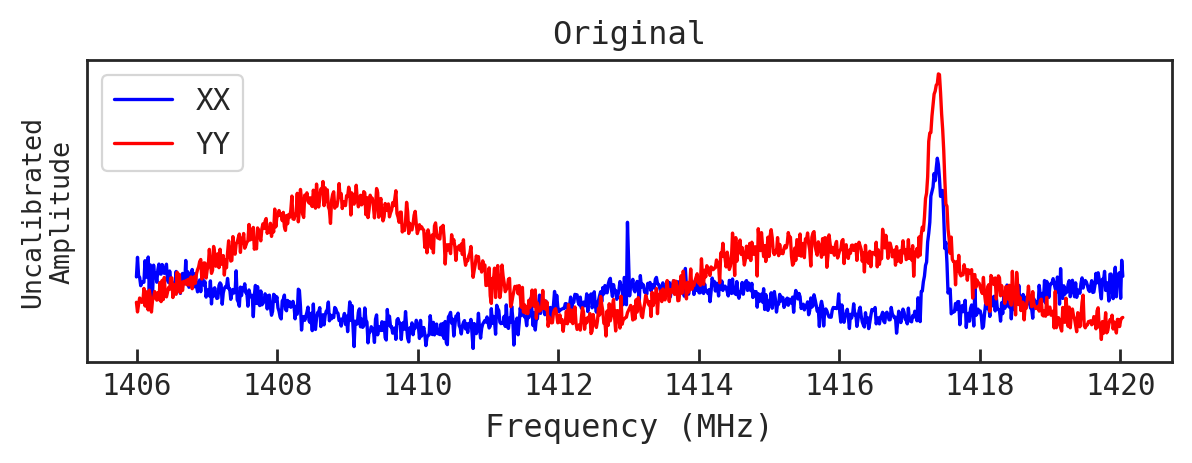

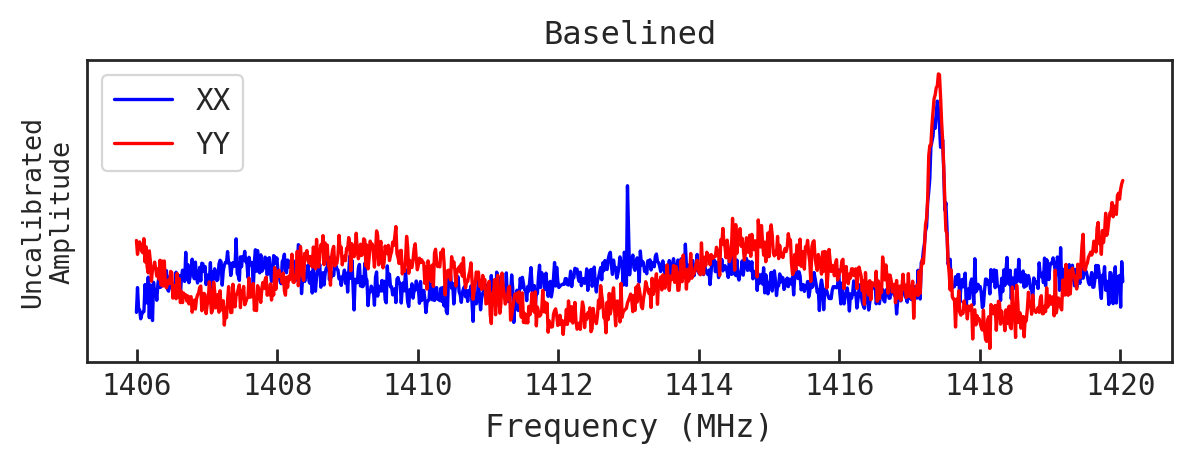

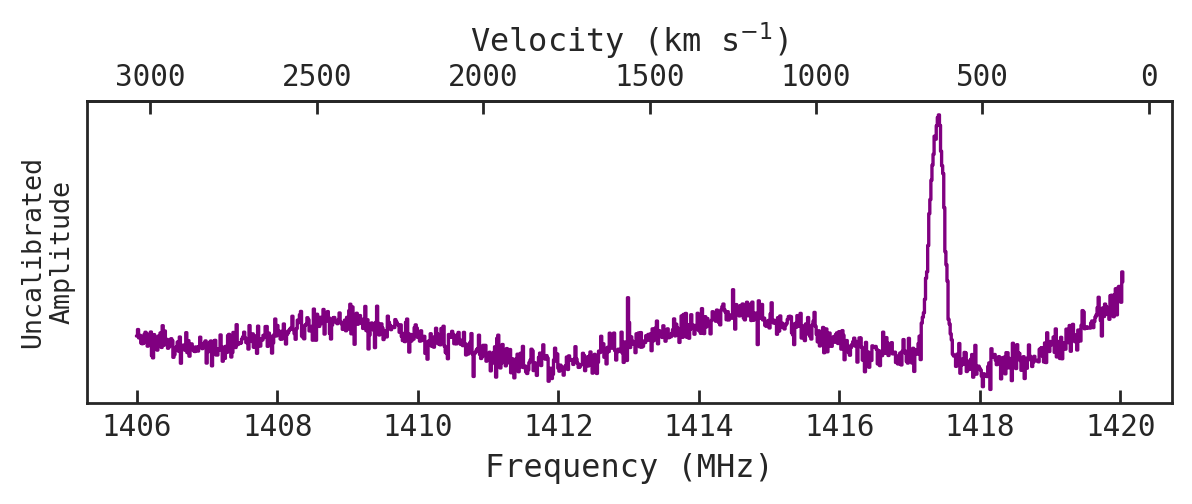

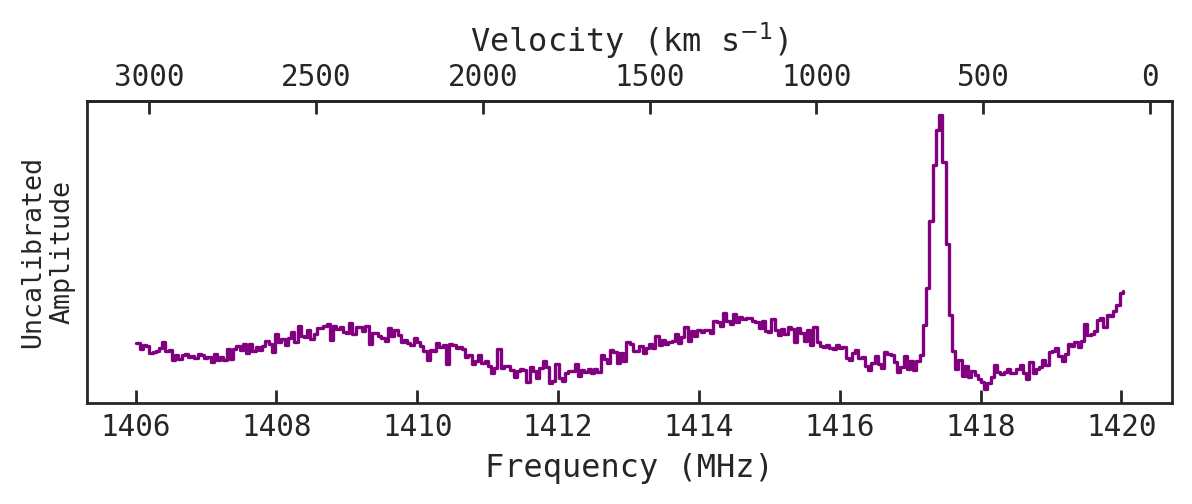

In [506]:
z_NGC628 = 0.00219

data_NGC628 = reduce_data('Data/NGC628_data.txt', z_NGC628, plot_steps=True, deg=5, smooth=True)

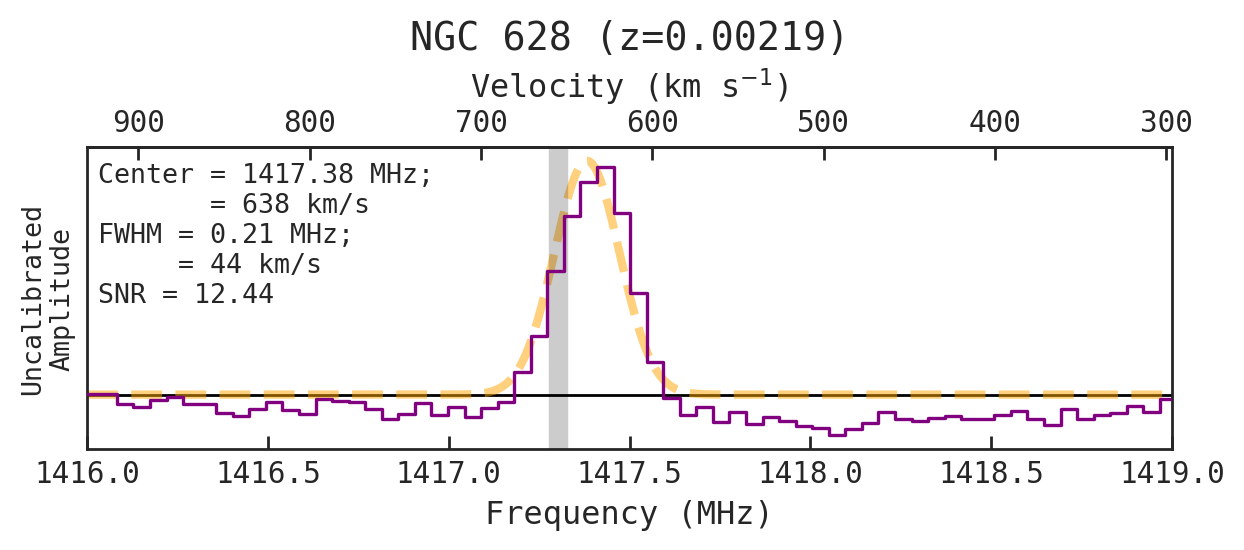

Fit Values (Assuming Gaussian)
------------------------------
Center: 1417.38 MHz; 638.18 km/s
Redshift: 0.0021
Sigma: -0.09 MHz; 19.02 km/s
FWHM: 0.21 MHz; 44.8 km/s


In [512]:
HI_mask_NGC628 = (data_NGC628['Freq2']>=1416) & (data_NGC628['Freq2']<=1419)
HI_fit_NGC628 = gauss_fit(data_NGC628['Freq2'][HI_mask_NGC628], data_NGC628['Spec2'][HI_mask_NGC628], z_NGC628)

amp, mu, sigma = HI_fit_NGC628
fwhm = abs(sigma*2.355)
sigma_kms = abs(f2v_HI(mu-sigma/2)-f2v_HI(mu+sigma/2))
fwhm_kms = abs(f2v_HI(mu-fwhm/2)-f2v_HI(mu+fwhm/2))

rms = np.std(data_NGC628['Spec2'][:20])
peak = np.sort(data_NGC628['Spec2'])[-1]
snr = peak/rms

plot_text = 'Center = '+str(np.round(mu,2))+' MHz;\n       = '+str(int(f2v_HI(mu)))+' km/s'
plot_text = plot_text + '\n' + 'FWHM = '+str(np.round(fwhm,2))+' MHz;\n     = '+str(int(fwhm_kms))+' km/s'
plot_text = plot_text + '\n' + 'SNR = '+str(np.round(snr,2))

new_xs = np.linspace(np.min(data_NGC628['Freq2']), np.max(data_NGC628['Freq2']), 10000)

plt.figure(figsize=(7,2))
plt.step(data_NGC628['Freq2'], data_NGC628['Spec2'], color='purple', label='Averaged Spectrum', zorder=3)
plt.plot(new_xs, gauss(new_xs,*HI_fit_NGC628), color='orange', linewidth=3, zorder=1, alpha=0.5, label='Fit Line', linestyle='dashed')
plt.axhline(0, color='k', linewidth=1.0, zorder=0)
plt.axvline(fHI.value/(z_NGC628+1), linewidth=7, zorder=1, alpha=0.2, color='k')
plt.ylabel('Uncalibrated\nAmplitude', fontsize='small')
plt.xlabel('Frequency (MHz)')
ax = plt.gca()
secax = ax.secondary_xaxis('top', functions=(f2v_HI, v2f_HI))
secax.set_xlabel('Velocity (km s$^{-1}$)')
ax.set_xlim([1416,1419])
ax.set_yticks([])
plt.text(0.01,0.95,plot_text,transform=ax.transAxes, va='top', fontsize='small')
# plt.legend(fontsize='small')
plt.title('NGC 628 (z='+str(z_NGC628)+')', fontsize='large')
plt.show()


print('Fit Values (Assuming Gaussian)')
print('------------------------------')
print('Center:', round(mu,2), 'MHz;', round(f2v_HI(mu),2), 'km/s')
print('Redshift:', round((fHI.value/mu)-1,4))
print('Sigma:', round(sigma,2), 'MHz;', round(sigma_kms,2), 'km/s')
print('FWHM:', round(fwhm,2), 'MHz;', round(fwhm_kms,2), 'km/s')

## NGC 1530

In [378]:
data_NGC1530 = t.read('Data/NGC1530_data.txt', format='ascii')
cols = ['Freq1','XX1','YY1','col1','col2','col3']

for i in range(6):
    data_NGC1530['col'+str(int(i+1))].name = cols[i]
    
data_NGC1530_HI = data_NGC1530['col1','col2','col3']

HI_mask = (data_NGC1530_HI['col1']>=(fHI.value/(1+z_NGC1530)-3)) & (data_NGC1530_HI['col1']<=(fHI.value/(1+z_NGC1530)+3))
data_NGC1530_HI[HI_mask].write('Data/NGC1530_data_crop.txt', format='ascii', overwrite=True)

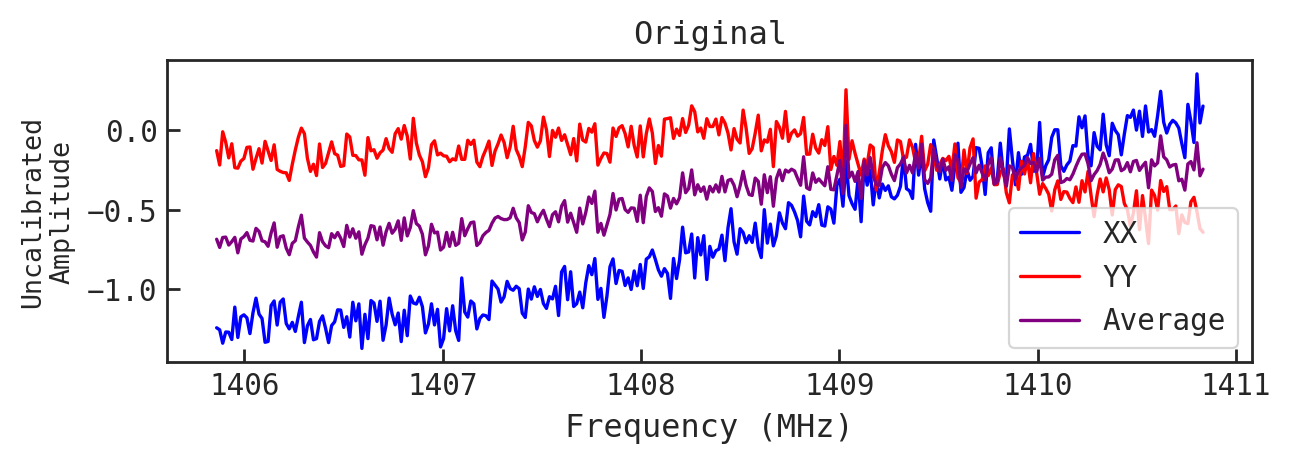

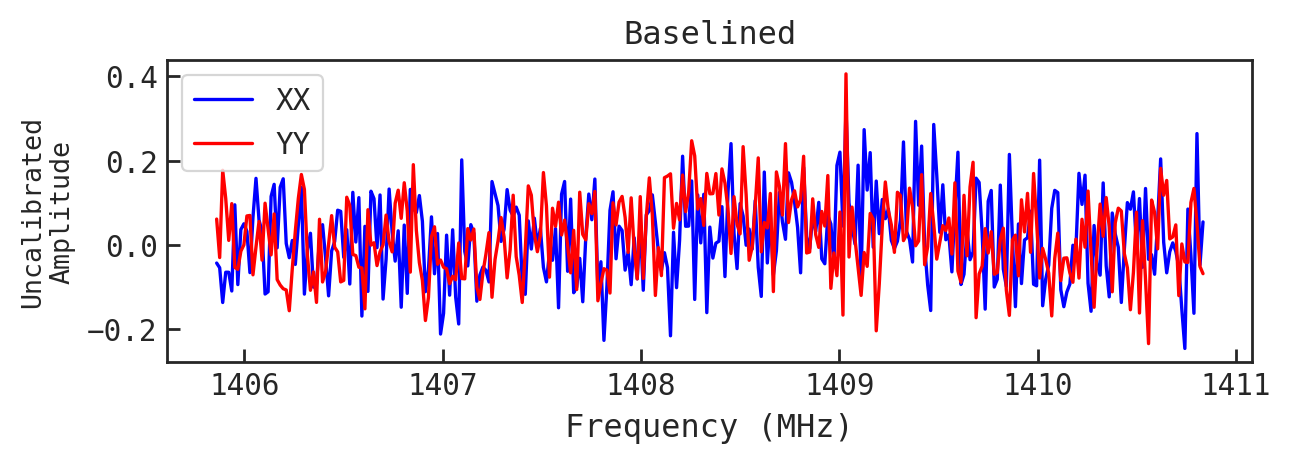

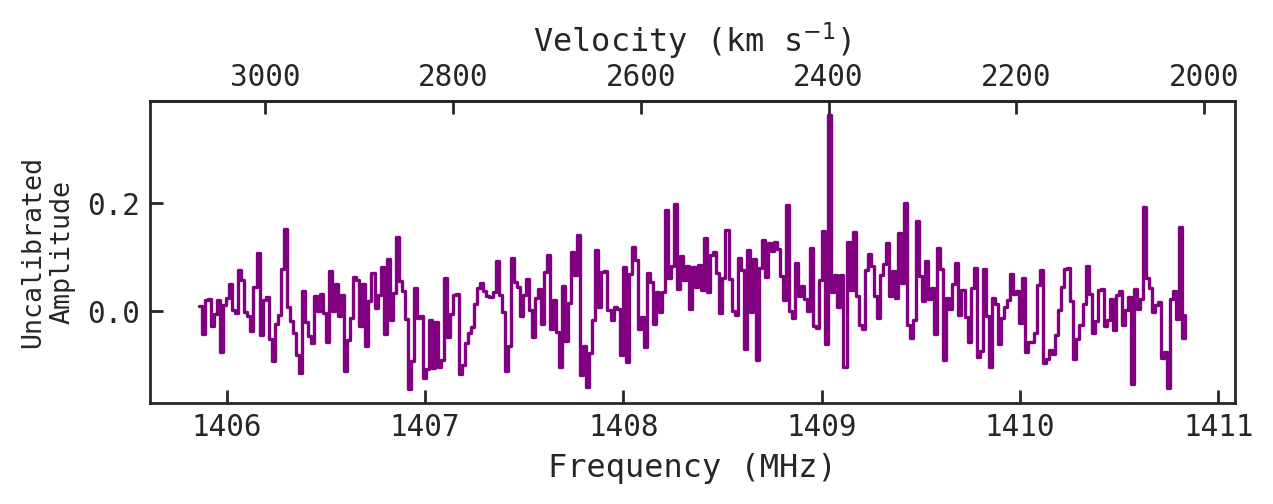

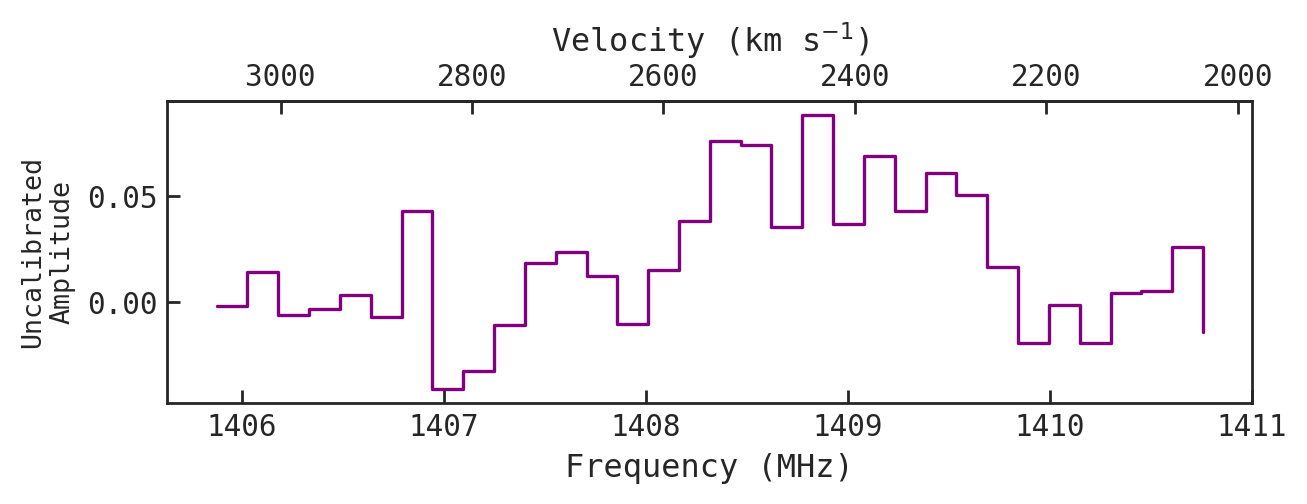

In [457]:
z_NGC1530 = 0.00820

data_NGC1530 = reduce_data('Data/NGC1530_data_crop.txt', z_NGC1530, plot_steps=True, deg=3, smooth=True, num=10)

/Users/hayley/opt/anaconda3/envs/research/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


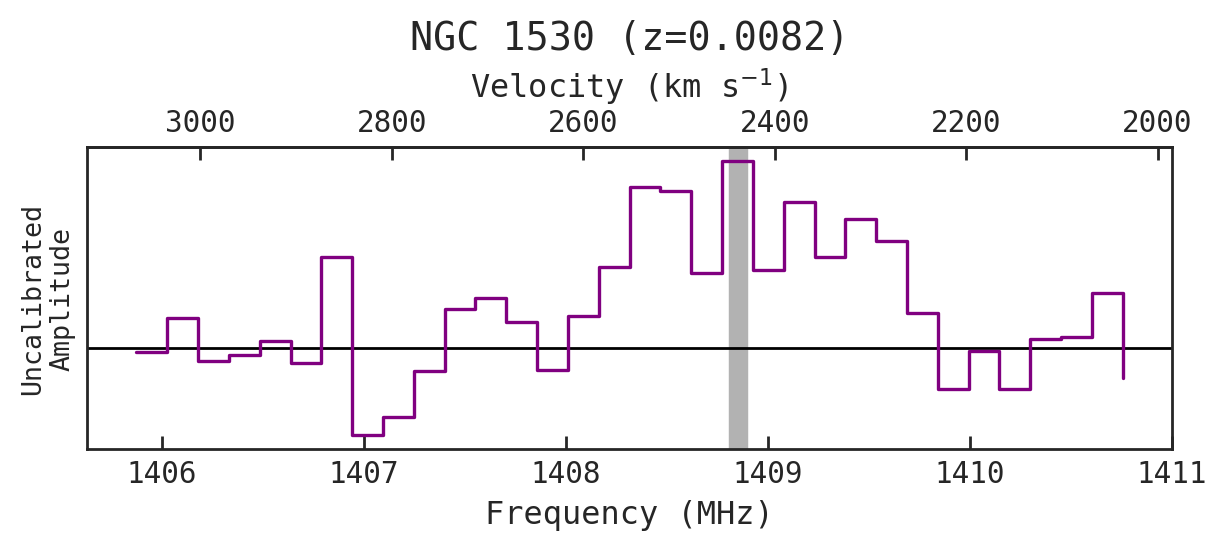

Fit Values (Assuming Gaussian)
------------------------------
Center: 1408.67 MHz; 2476.64 km/s
Redshift: 0.0083
Sigma: -0.0 MHz; -0.35 km/s
FWHM: -0.0 MHz; -0.82 km/s


In [517]:
# HI_mask_NGC1530 = (data_NGC1530['Freq2']>=fHI.value/(1+z_NGC1530)-3) & (data_NGC1530['Freq2']<=fHI.value/(1+z_NGC1530)+3)
HI_fit_NGC1530 = gauss_fit(data_NGC1530['Freq2'], data_NGC1530['Spec2'], z_NGC1530)

# amp, mu, sigma = HI_fit_NGC1530
# fwhm = sigma*2.355
# sigma_kms = f2v_HI(mu-sigma/2)-f2v_HI(mu+sigma/2) 
# fwhm_kms = f2v_HI(mu-fwhm/2)-f2v_HI(mu+fwhm/2) 


plt.figure(figsize=(7,2))
plt.step(data_NGC1530['Freq2'], data_NGC1530['Spec2'], color='purple', label='Averaged Spectrum', zorder=3)
# plt.plot(data_NGC1530['Freq2'], gauss(data_NGC1530['Freq2'],*HI_fit_NGC1530), color='k', linewidth=7, zorder=1, alpha=0.3, label='Fit Line')
plt.ylabel('Uncalibrated\nAmplitude', fontsize='small')
plt.xlabel('Frequency (MHz)')

ax = plt.gca()
secax = ax.secondary_xaxis('top', functions=(f2v_HI, v2f_HI))
secax.set_xlabel('Velocity (km s$^{-1}$)')
ax.axvline(fHI.value/(1+z_NGC1530), linewidth=7, zorder=1, alpha=0.3, color='k')
plt.axhline(0, color='k', linewidth=1.0, zorder=0)
# ax.set_xlim([1408,1409.5])
ax.set_yticks([])
# plt.legend(fontsize='small')
plt.title('NGC 1530 (z='+str(z_NGC1530)+')', fontsize='large')
plt.show()


print('Fit Values (Assuming Gaussian)')
print('------------------------------')
print('Center:', round(mu,2), 'MHz;', round(f2v_HI(mu),2), 'km/s')
print('Redshift:', round((fHI.value/mu)-1,4))
print('Sigma:', round(sigma,2), 'MHz;', round(sigma_kms,2), 'km/s')
print('FWHM:', round(fwhm,2), 'MHz;', round(fwhm_kms,2), 'km/s')

## NGC 4565

In [358]:
z_NGC4565 = 0.00428

fHI/(1+z_NGC4565)

<Quantity 1414.35232206 MHz>

In [385]:
data_NGC4565 = t.read('Data/NGC4565_data.txt', format='ascii')
cols = ['Freq1','XX1','YY1','col1','col2','col3']

for i in range(6):
    data_NGC4565['col'+str(int(i+1))].name = cols[i]
    
data_NGC4565_HI = data_NGC4565['col1','col2','col3']

HI_mask = (data_NGC4565_HI['col1']>=(fHI.value/(1+z_NGC4565)-3)) & (data_NGC4565_HI['col1']<=(fHI.value/(1+z_NGC4565)+3))
data_NGC4565_HI[HI_mask].write('Data/NGC4565_data_crop.txt', format='ascii', overwrite=True)

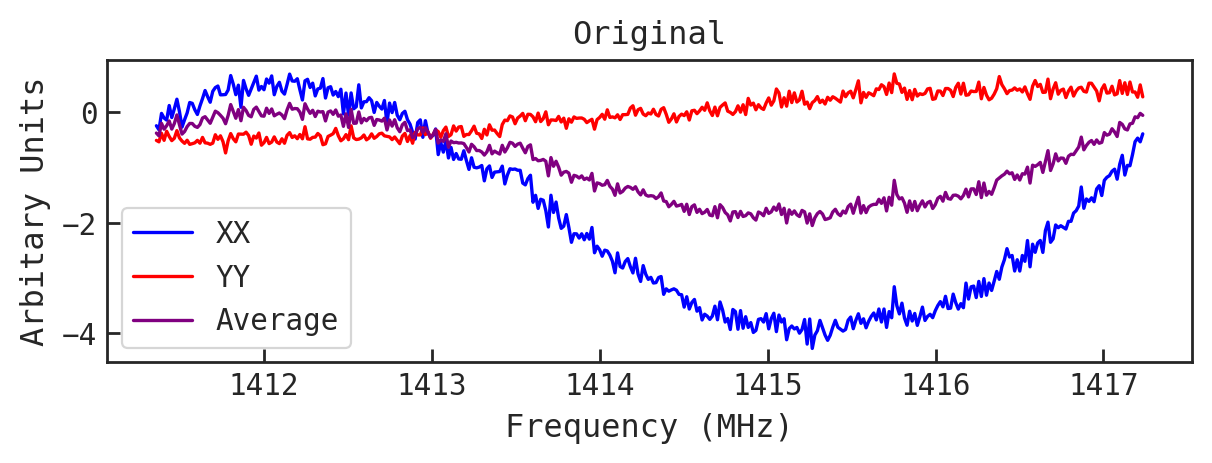

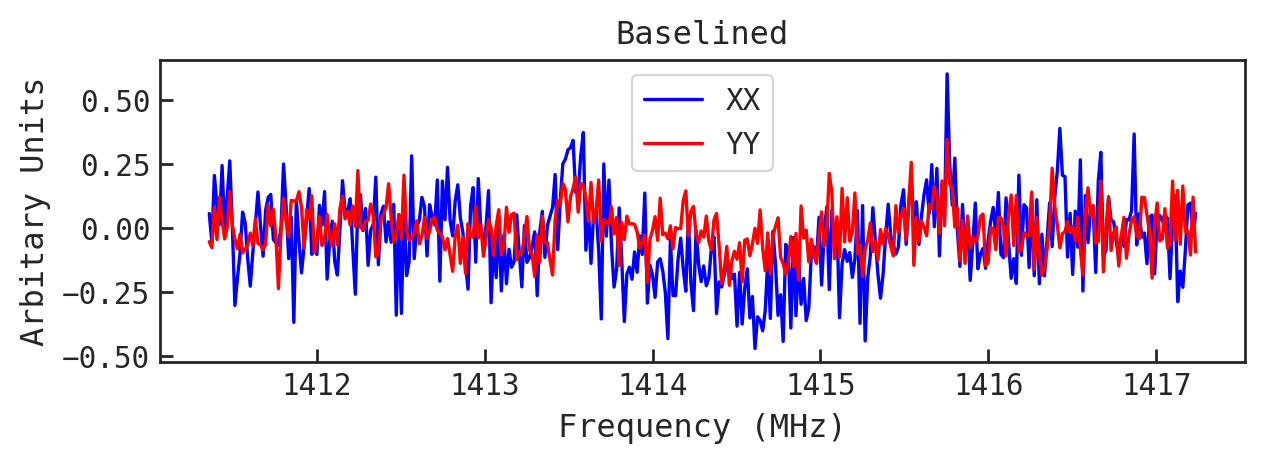

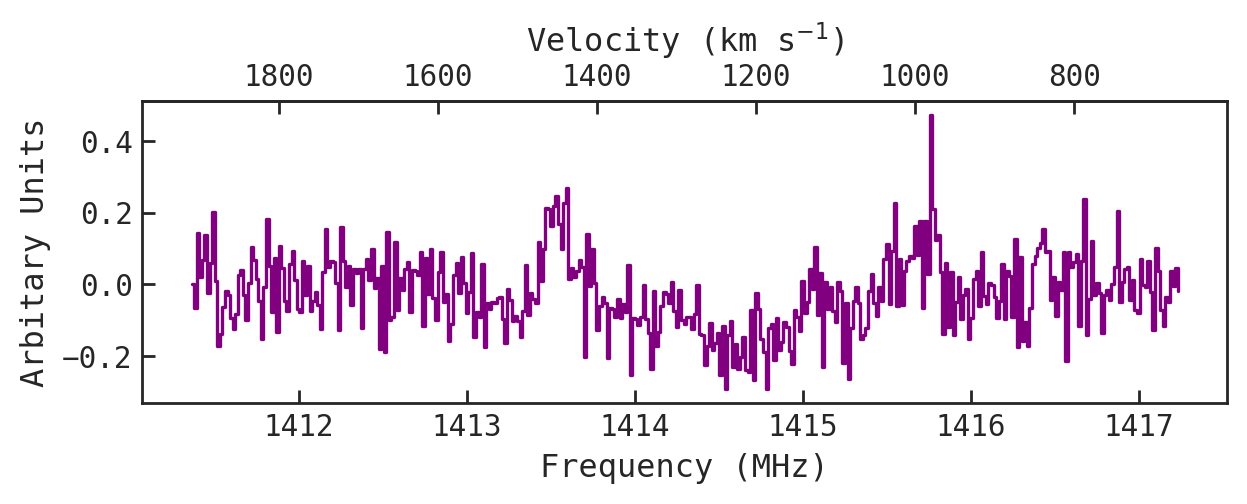

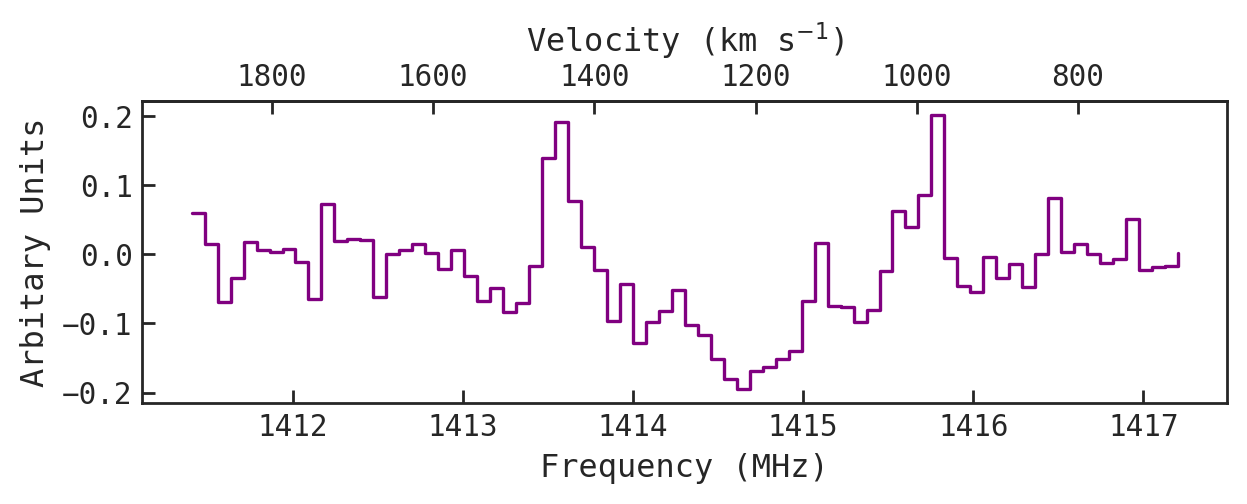

In [388]:
data_NGC4565 = reduce_data('Data/NGC4565_data_crop.txt', z_NGC4565, plot_steps=True, deg=4, smooth=True, num=5)

/Users/hayley/opt/anaconda3/envs/research/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


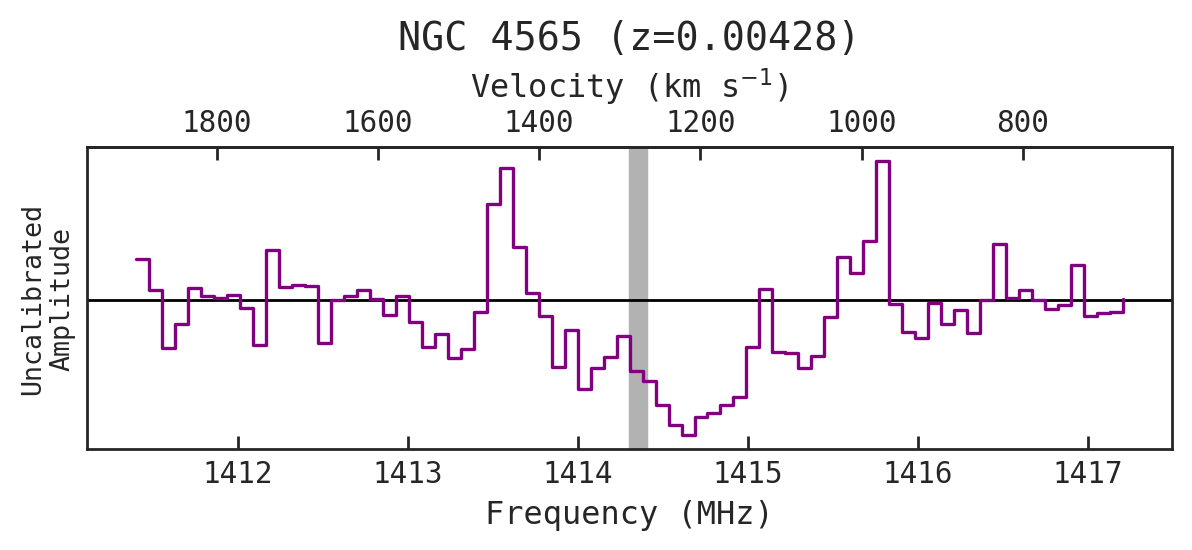

Fit Values (Assuming Gaussian)
------------------------------
Center: 1414.35 MHz; 1277.64 km/s
Redshift: 0.0043
Sigma: -0.0 MHz; -0.57 km/s
FWHM: -0.01 MHz; -1.34 km/s


In [515]:
# HI_mask_NGC4565 = (data_NGC4565['Freq2']>=1405) & (data_NGC4565['Freq2']<=1420)
HI_fit_NGC4565 = gauss_fit(data_NGC4565['Freq2'], data_NGC4565['Spec2'], z_NGC4565)

amp, mu, sigma = HI_fit_NGC4565
fwhm = sigma*2.355
sigma_kms = f2v_HI(mu-sigma/2)-f2v_HI(mu+sigma/2) 
fwhm_kms = f2v_HI(mu-fwhm/2)-f2v_HI(mu+fwhm/2) 


plt.figure(figsize=(7,2))
plt.step(data_NGC4565['Freq2'], data_NGC4565['Spec2'], color='purple', label='Averaged Spectrum', zorder=3)
# plt.plot(data_NGC4565['Freq2'], gauss(data_NGC4565['Freq2'],*HI_fit_NGC4565), color='k', linewidth=7, zorder=1, alpha=0.3, label='Fit Line')
plt.ylabel('Uncalibrated\nAmplitude', fontsize='small')
plt.xlabel('Frequency (MHz)')
ax = plt.gca()
secax = ax.secondary_xaxis('top', functions=(f2v_HI, v2f_HI))
secax.set_xlabel('Velocity (km s$^{-1}$)')
ax.axvline(fHI.value/(1+z_NGC4565), linewidth=7, zorder=1, alpha=0.3, color='k')
plt.axhline(0, color='k', linewidth=1.0, zorder=0)
# ax.set_xlim([1405,1420])
ax.set_yticks([])
# plt.legend(fontsize='small')
plt.title('NGC 4565 (z='+str(z_NGC4565)+')', fontsize='large')
plt.show()


print('Fit Values (Assuming Gaussian)')
print('------------------------------')
print('Center:', round(mu,2), 'MHz;', round(f2v_HI(mu),2), 'km/s')
print('Redshift:', round((fHI.value/mu)-1,4))
print('Sigma:', round(sigma,2), 'MHz;', round(sigma_kms,2), 'km/s')
print('FWHM:', round(fwhm,2), 'MHz;', round(fwhm_kms,2), 'km/s')

## NGC 3976

In [463]:
z_NGC3976 = 0.00833

fHI/(1+z_NGC3976)

<Quantity 1408.67151627 MHz>

In [464]:
data_NGC3976 = t.read('Data/NGC3976_data.txt', format='ascii')
cols = ['Freq1','XX1','YY1','col1','col2','col3']

for i in range(6):
    data_NGC3976['col'+str(int(i+1))].name = cols[i]
    
data_NGC3976_HI = data_NGC3976['col1','col2','col3']

HI_mask = (data_NGC3976_HI['col1']>=(fHI.value/(1+z_NGC3976)-3)) & (data_NGC3976_HI['col1']<=(fHI.value/(1+z_NGC3976)+3))
data_NGC3976_HI[HI_mask].write('Data/NGC3976_data_crop.txt', format='ascii', overwrite=True)

/Users/hayley/opt/anaconda3/envs/research/lib/python3.7/site-packages/ipykernel_launcher.py:25: RankWarning: Polyfit may be poorly conditioned
/Users/hayley/opt/anaconda3/envs/research/lib/python3.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned


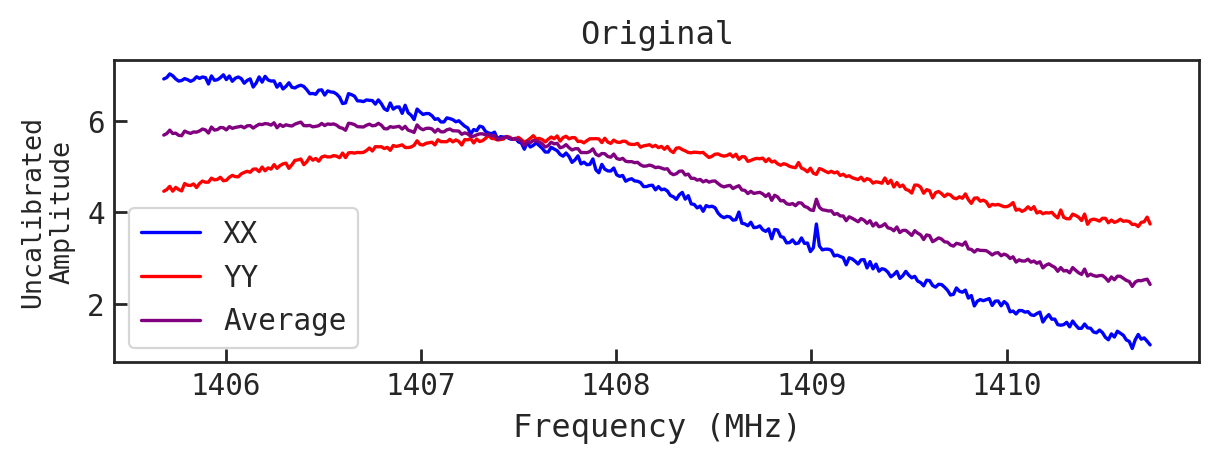

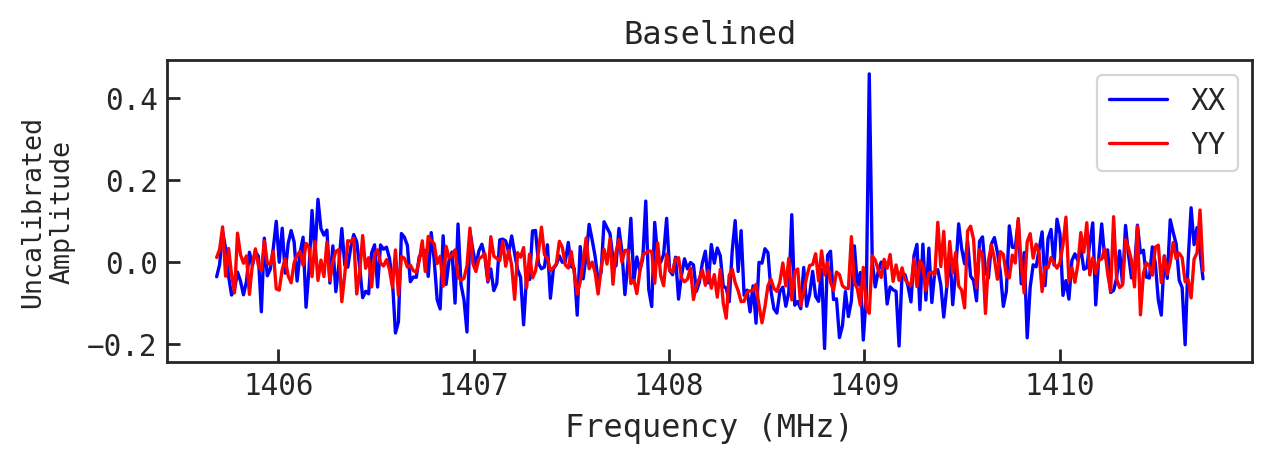

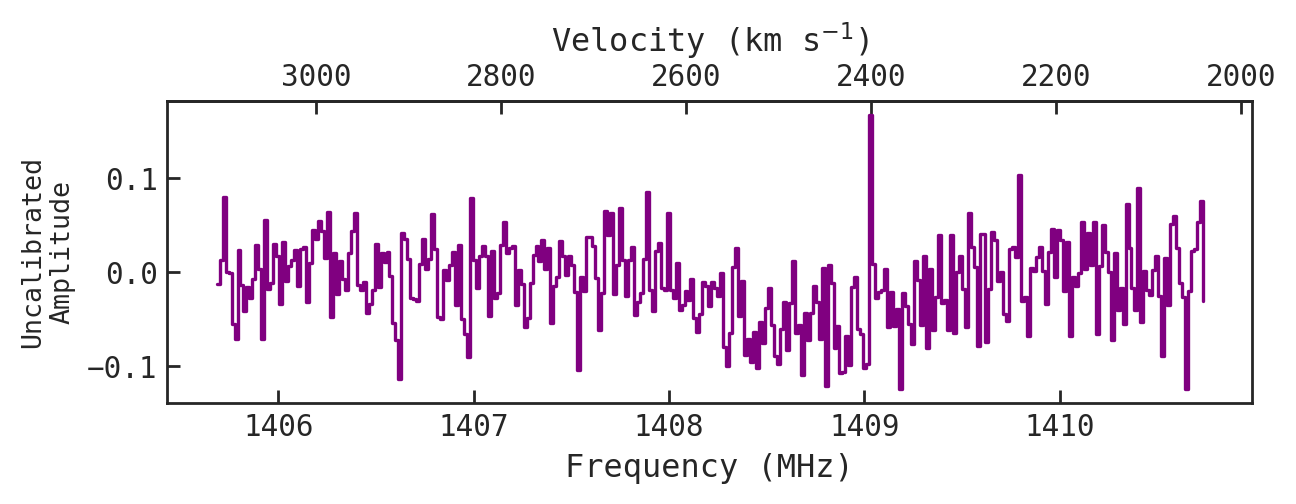

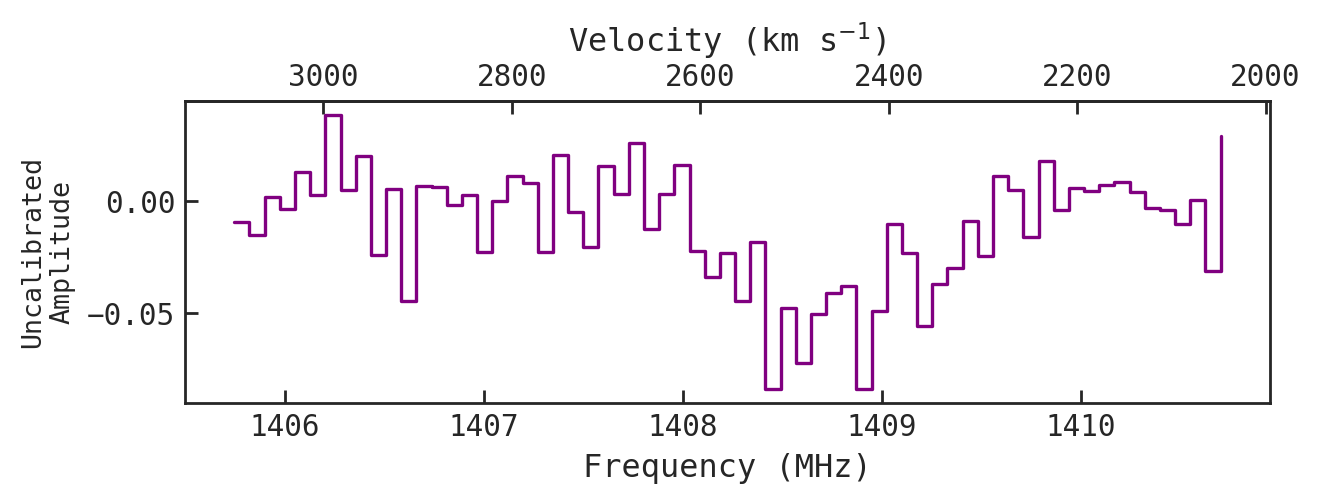

In [465]:
z_NGC3976 = 0.00833

data_NGC3976 = reduce_data('Data/NGC3976_data_crop.txt', z_NGC3976, plot_steps=True, deg=5, smooth=True, num=5)

In [466]:
fHI/(1+z_NGC3976)

<Quantity 1408.67151627 MHz>

/Users/hayley/opt/anaconda3/envs/research/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


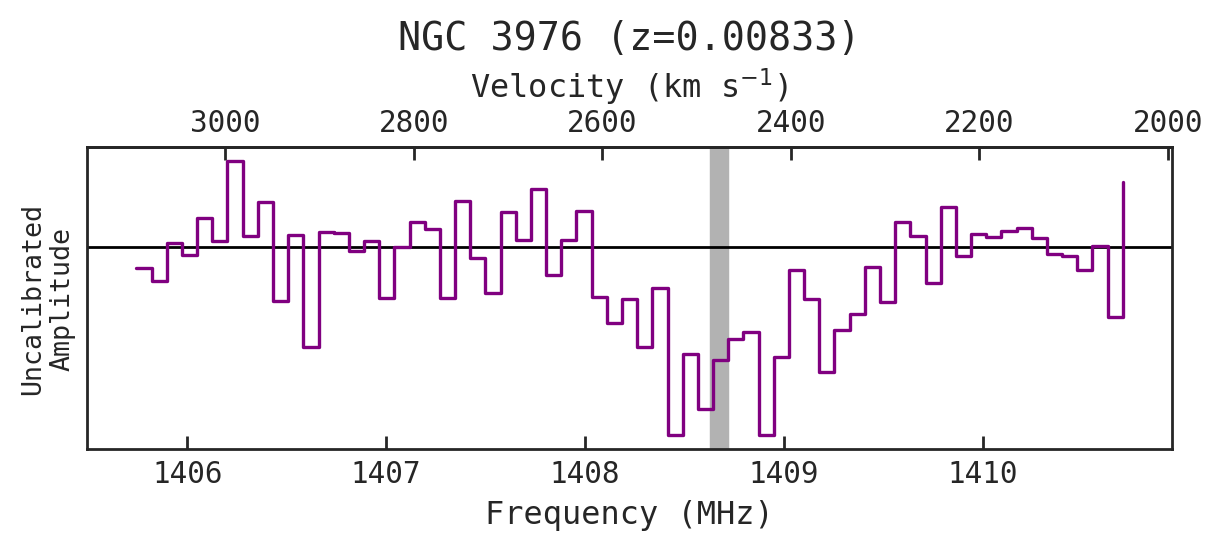

Fit Values (Assuming Gaussian)
------------------------------
Center: 1408.67 MHz; 2476.64 km/s
Redshift: 0.0083
Sigma: -0.0 MHz; -0.35 km/s
FWHM: -0.0 MHz; -0.82 km/s


In [516]:
HI_mask_NGC3976 = (data_NGC3976['Freq2']>=1407) & (data_NGC3976['Freq2']<=1411)
HI_fit_NGC3976 = gauss_fit(data_NGC3976['Freq2'], data_NGC3976['Spec2'], z_NGC3976)

amp, mu, sigma = HI_fit_NGC3976
fwhm = sigma*2.355
sigma_kms = f2v_HI(mu-sigma/2)-f2v_HI(mu+sigma/2) 
fwhm_kms = f2v_HI(mu-fwhm/2)-f2v_HI(mu+fwhm/2) 



plt.figure(figsize=(7,2))
plt.step(data_NGC3976['Freq2'], data_NGC3976['Spec2'], color='purple', label='Averaged Spectrum', zorder=3)
# plt.plot(data_NGC3976['Freq2'], gauss(data_NGC3976['Freq2'],*HI_fit_NGC3976), color='k', linewidth=7, zorder=1, alpha=0.3, label='Fit Line')
plt.ylabel('Uncalibrated\nAmplitude', fontsize='small')
plt.xlabel('Frequency (MHz)')
plt.axhline(0, color='k', linewidth=1.0, zorder=0)
ax = plt.gca()
secax = ax.secondary_xaxis('top', functions=(f2v_HI, v2f_HI))
secax.set_xlabel('Velocity (km s$^{-1}$)')
ax.axvline(fHI.value/(1+z_NGC3976), linewidth=7, zorder=1, alpha=0.3, color='k')
# ax.set_xlim([1405,1411])
ax.set_yticks([])
# plt.legend(fontsize='small')
plt.title('NGC 3976 (z='+str(z_NGC3976)+')', fontsize='large')
plt.show()


print('Fit Values (Assuming Gaussian)')
print('------------------------------')
print('Center:', round(mu,2), 'MHz;', round(f2v_HI(mu),2), 'km/s')
print('Redshift:', round((fHI.value/mu)-1,4))
print('Sigma:', round(sigma,2), 'MHz;', round(sigma_kms,2), 'km/s')
print('FWHM:', round(fwhm,2), 'MHz;', round(fwhm_kms,2), 'km/s')

## NGC 4559

In [469]:
z_NGC4559 = 0.00271

fHI/(1+z_NGC4559)

<Quantity 1416.56685383 MHz>

In [470]:
data_NGC4559 = t.read('Data/NGC4559_data.txt', format='ascii')
cols = ['Freq1','XX1','YY1','col1','col2','col3']

for i in range(6):
    data_NGC4559['col'+str(int(i+1))].name = cols[i]
    
data_NGC4559_HI = data_NGC4559['col1','col2','col3']

HI_mask = (data_NGC4559_HI['col1']>=(fHI.value/(1+z_NGC4559)-3)) & (data_NGC4559_HI['col1']<=(fHI.value/(1+z_NGC4559)+3))
data_NGC4559_HI[HI_mask].write('Data/NGC4559_data_crop.txt', format='ascii', overwrite=True)

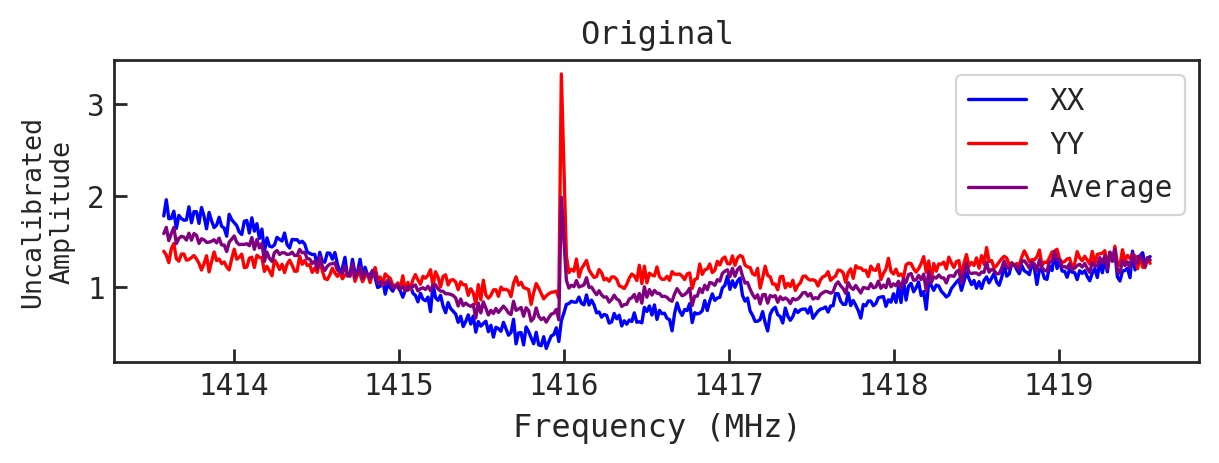

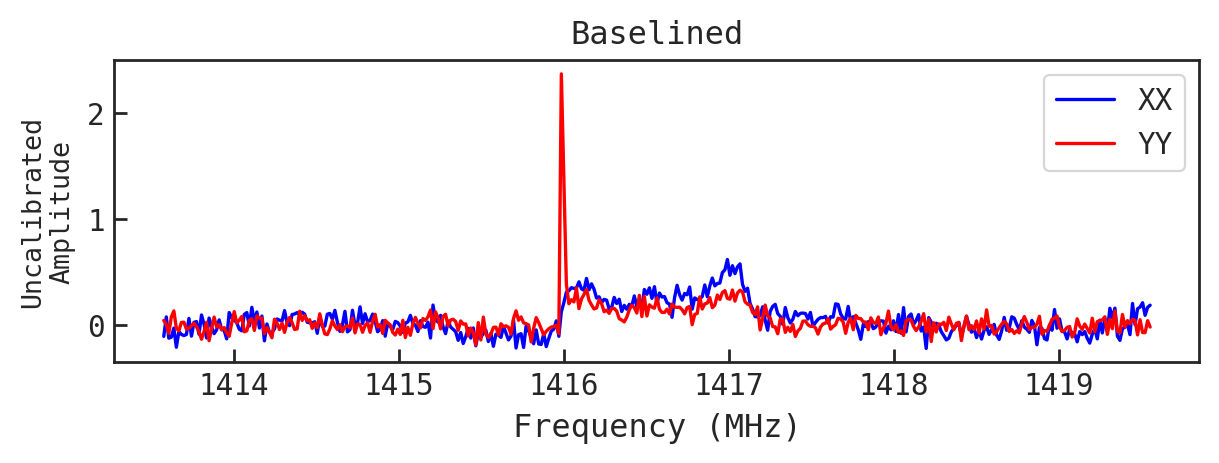

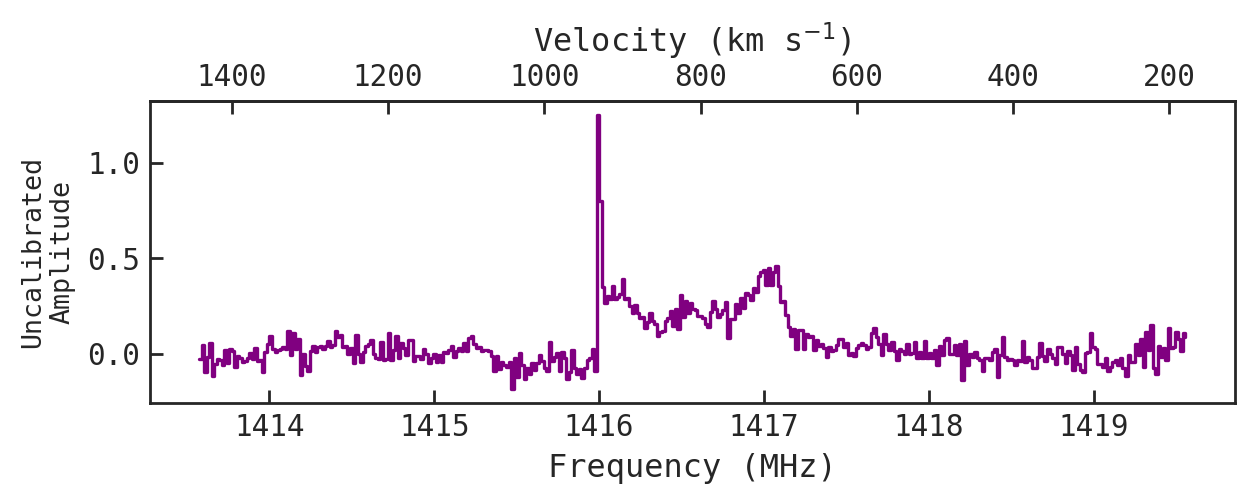

In [471]:
z_NGC4559 = 0.00271

data_NGC4559 = reduce_data('Data/NGC4559_data_crop.txt', z_NGC4559, plot_steps=True)

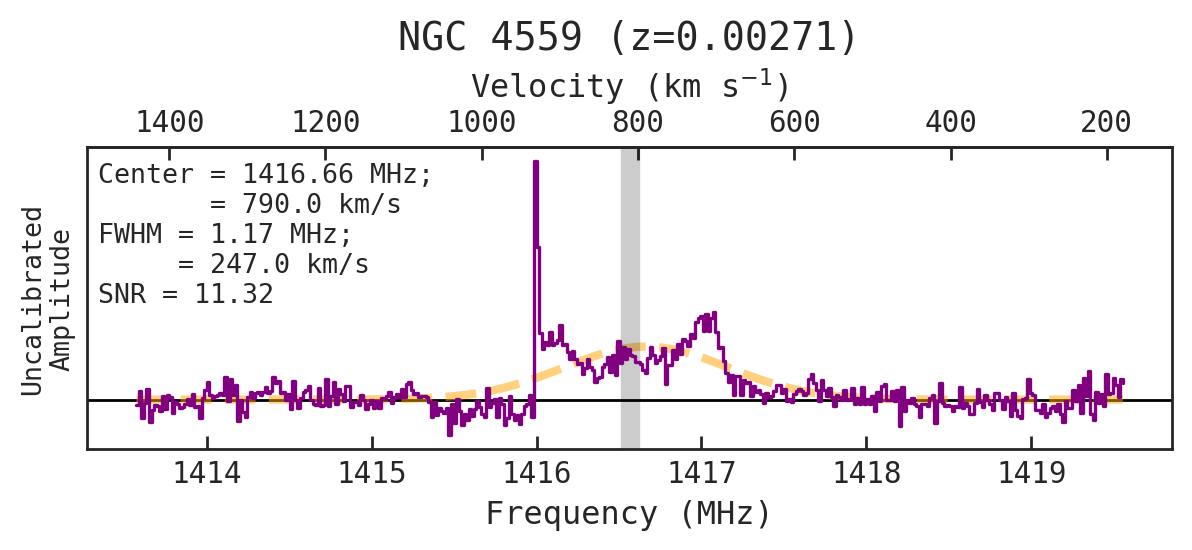

Fit Values (Assuming Gaussian)
------------------------------
Center: 1416.66 MHz; 789.71 km/s
Redshift: 0.0026
Sigma: 0.5 MHz; 104.99 km/s
FWHM: 1.17 MHz; 247.26 km/s
Peak SNR:


In [518]:
# HI_mask_NGC4559 = (data_NGC4559['Freq2']>=1414) & (data_NGC4559['Freq2']<=1418)
HI_fit_NGC4559 = gauss_fit(data_NGC4559['Freq2'], data_NGC4559['Spec2'], z_NGC4559)

amp, mu, sigma = HI_fit_NGC4559
fwhm = sigma*2.355
sigma_kms = f2v_HI(mu-sigma/2)-f2v_HI(mu+sigma/2) 
fwhm_kms = f2v_HI(mu-fwhm/2)-f2v_HI(mu+fwhm/2) 

rms = np.std(data_NGC4559['Spec2'][:20])
peak = np.sort(data_NGC4559['Spec2'])[-2]
snr = peak/rms

plot_text = 'Center = '+str(np.round(mu,2))+' MHz;\n       = '+str(np.round(f2v_HI(mu)))+' km/s'
plot_text = plot_text + '\n' + 'FWHM = '+str(np.round(fwhm,2))+' MHz;\n     = '+str(np.round(fwhm_kms))+' km/s'
plot_text = plot_text + '\n' + 'SNR = '+str(np.round(snr,2))

new_xs = np.linspace(np.min(data_NGC4559['Freq2']), np.max(data_NGC4559['Freq2']), 10000)

plt.figure(figsize=(7,2))
plt.step(data_NGC4559['Freq2'], data_NGC4559['Spec2'], color='purple', label='Averaged Spectrum', zorder=3)
plt.plot(new_xs, gauss(new_xs,*HI_fit_NGC4559), color='orange', linewidth=3, zorder=1, alpha=0.5, label='Fit Line', linestyle='dashed')
plt.axhline(0, color='k', linewidth=1.0, zorder=0)
plt.axvline(fHI.value/(z_NGC4559+1), linewidth=7, zorder=1, alpha=0.2, color='k')
plt.ylabel('Uncalibrated\nAmplitude', fontsize='small')
plt.xlabel('Frequency (MHz)')

ax = plt.gca()
secax = ax.secondary_xaxis('top', functions=(f2v_HI, v2f_HI))
secax.set_xlabel('Velocity (km s$^{-1}$)')
# ax.set_xlim([1414,1418])
ax.set_yticks([])
plt.text(0.01,0.95,plot_text,transform=ax.transAxes, va='top', fontsize='small')
# plt.legend(fontsize='small')
plt.title('NGC 4559 (z='+str(z_NGC4559)+')', fontsize='large')
plt.show()


print('Fit Values (Assuming Gaussian)')
print('------------------------------')
print('Center:', round(mu,2), 'MHz;', round(f2v_HI(mu),2), 'km/s')
print('Redshift:', round((fHI.value/mu)-1,4))
print('Sigma:', round(sigma,2), 'MHz;', round(sigma_kms,2), 'km/s')
print('FWHM:', round(fwhm,2), 'MHz;', round(fwhm_kms,2), 'km/s')
print('Peak SNR:', )